In [10]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import root_mean_squared_error, mean_absolute_error


operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

import extraction_squares

In [5]:
# import the most corrolated variables from the time series
vars_selected = pd.read_csv('pre_processing/feature_selection/fs_corr_timeseries/corr_inst_max_30.csv')
vars_selected = vars_selected['Unnamed: 0'].values

In [31]:
stats = ['max', 'min', 'mean', 'std']
name_of_variable_levels = vars_selected
all_series = 'yes'

# shape all_data as the timeseries data
X_all_vars = {}

for var in name_of_variable_levels:
    var = var.rsplit("_", 1)[0]
    if var == 'sea_surface_temperature':
        continue
    for stat in stats:
        var_stat = f'{var}_{stat}'
        #if var_stat == f'instantaneous_10m_wind_gust_{stat}':
        #storm_data = []
        if all_series == 'yes':
            var_temp_non_eu = pd.read_csv(f'data/time_series_1h_non_EU/{var}/{var}_{stat}.csv')
            # reverse the order of the columns
            var_temp_non_eu = var_temp_non_eu.iloc[:, ::-1]
            var_temp_eu = pd.read_csv(f'data/time_series_1h_EU/{var}/{var}_{stat}.csv')
            var_temp = pd.concat([var_temp_non_eu, var_temp_eu], axis=1)
        else:
            var_temp = pd.read_csv(f'data/time_series_1h_non_EU/{var}/{var}_{stat}.csv')
        var_temp = var_temp.drop(columns=['Unnamed: 0', 'storm_index'])
        # select only the 12 first hours (represented by the 12 first columns)
        if all_series == 'no':
            var_temp = var_temp.iloc[:, :12]
        #var_temp_2 = var_temp.drop(columns=['storm_index'])
        var_temp_reshape = var_temp.to_numpy().reshape((var_temp.shape[0]*var_temp.shape[1]))
        X_all_vars[f'{var_stat}'] = var_temp_reshape

# Assuming all_vars is populated as a dictionary
df_X_all_vars = pd.DataFrame(X_all_vars)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(df_X_all_vars)

y_all = {}

var = 'instantaneous_10m_wind_gust'
stat = 'max'
var_stat = f'{var}_{stat}'
if all_series == 'yes':
    var_temp_non_eu = pd.read_csv(f'data/time_series_1h_non_EU/{var}/{var}_{stat}.csv')
    # reverse the order of the columns
    var_temp_non_eu = var_temp_non_eu.iloc[:, ::-1]
    var_temp_eu = pd.read_csv(f'data/time_series_1h_EU/{var}/{var}_{stat}.csv')
    var_temp = pd.concat([var_temp_non_eu, var_temp_eu], axis=1)
else:
    var_temp = pd.read_csv(f'data/time_series_1h_EU/{var}/{var}_{stat}.csv')
var_temp = var_temp.drop(columns=['Unnamed: 0', 'storm_index', 'storm_name','start_date'])
# select only the 12 first hours (represented by the 12 first columns)
if all_series == 'no':
    var_temp = var_temp.iloc[:, :12]
#var_temp_2 = var_temp.drop(columns=['storm_index'])
var_temp_reshape = var_temp.to_numpy().reshape((var_temp.shape[0]*var_temp.shape[1]))
y_all[f'{var_stat}'] = var_temp_reshape

df_y = pd.DataFrame(y_all)

In [32]:
# separate the data into training and testing
X_train = scaled_X[:int(0.8*len(scaled_X))]
X_test = scaled_X[int(0.8*len(scaled_X)):]
y_train = df_y[:int(0.8*len(df_y))]
y_test = df_y[int(0.8*len(df_y)):]

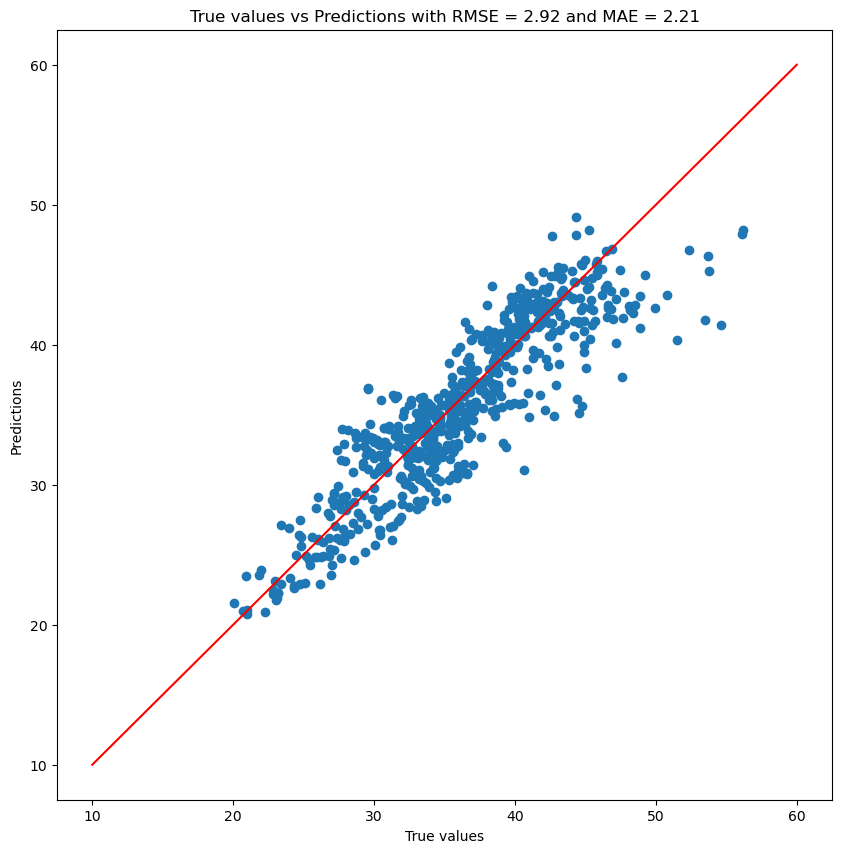

In [33]:
# fit the model
model = XGBRegressor(n_jobs=-1)
model.fit(X_train,y_train)

# predictions
y_pred = model.predict(X_test)

# check the rmse and mae
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# plot the predictions
plt.figure(figsize=(10, 10))
plt.plot(y_test, y_pred, 'o')
# plot the line
x = np.linspace(10, 60, 100)
plt.plot(x, x, color='r')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('True values vs Predictions with RMSE = {:.2f} and MAE = {:.2f}'.format(rmse, mae))
plt.show()

In [34]:
# Initialize the sequential feature selector
sfs = SequentialFeatureSelector(
                                model,  # Use the same model as before
                                n_features_to_select=5,  # Select 5 features
                                direction='forward',  # Forward selection
                                n_jobs=-1  # Use all available cores
                                )   

# Fit the selector
sfs.fit(scaled_X, df_y.to_numpy().ravel())

# Get the selected feature indices
selected_indices = sfs.get_support(indices=True)

# Get the names of the selected features
selected_features = df_X_all_vars.columns[selected_indices]
print("Selected features:", selected_features)

Selected features: Index(['10m_u_component_of_wind_max', 'surface_latent_heat_flux_min',
       'mean_surface_sensible_heat_flux_std', 'geopotential_1000_mean',
       '10m_v_component_of_wind_max'],
      dtype='object')
